# this notebook covers personlity analysis based on text using (MBTI) psychological model by making 1 models for all spectrum/field.
# it consists of 2 models, one made from scratch and the other using pretrained model.

### the notebook goes through:
- #### Discovering data, cleaning it.
- #### Constucting models.
- #### Training models.
- #### Testing  models and evaluating their results.
- #### Calculating some metrics like confusion matrix.

In [ ]:
import numpy as np
import pandas as pd
import os
import nltk
!pip install transformers
import transformers

#### listing class types to be used later when indexing

In [ ]:
per_types = ['ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INFP','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']

#### making google colab accesses google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### reading the data

In [ ]:
data = pd.read_csv("drive/MyDrive/kaggle.csv")
data = data.iloc[:,:2]

##### listing the data classes

In [ ]:
types = np.unique(data.type.values)
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

#### adding index for each data class type

In [ ]:
def get_type_index(string):
    return list(types).index(string)
data['type_index'] = data['type'].apply(get_type_index)

#### showing first 16 sample of the data

In [ ]:
data.head(16)

,type,text,type_index
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,8
1,ENTP,'I'm finding the lack of me in these posts ver...,3
2,INTP,'Good one _____ https://www.youtube.com/wat...,11
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",10
4,ENTJ,'You're fired.|||That's another silly misconce...,2
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,10
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",8
7,INTJ,'I tend to build up a collection of things on ...,10
8,INFJ,"I'm not sure, that's a good question. The dist...",8
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,11


##### showing data before any preprocessing or cleaning

In [ ]:
data.text.values[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

#### importing some packages and libraries used in data cleaning and preprocessing

In [ ]:
import nltk

# Packages needed to be downloaded once
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')

# lists of words needed to be loaded once
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words = [w for w in stop_words if 't' not in w or 'n' not in w]
stop_words.append("between")
stop_words.append("into")

print(stop_words)
# porter = nltk.PorterStemmer()
# lancaster = nltk.LancasterStemmer()
# wnl = nltk.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['such', 'isn', 'with', 'being', 's', 'am', 'off', 'most', 'over', 't', 'any', 'haven', 'up', 'itself', 'aren', 'him', 'why', "you'll", 'll', 'shan', 'above', "you'd", 'below', 'themselves', 've', "that'll", 'o', 'yours', 'i', 'how', "you're", 'will', 'their', 'that', 'if', 'yourselves', 'ain', 'each', 'herself', 're',

#### preprocessing function that cleans data(removes symbols,unwanted words,etc...)

In [ ]:
import string
import re

def clean_text(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = [i for i in words if not "http" in i]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    #remove digits
    words = re.sub(" \d+", " ", words)
    
    words_tokens =  nltk.tokenize.word_tokenize(words)
    # remove the stop words
    filtered_tokens = [w for w in words_tokens if w not in stop_words]
    # remove redundent words
    filtered_tokens = list(dict.fromkeys(filtered_tokens))
    # remove single characters
    filtered_tokens = [w for w in filtered_tokens if len(w)>2]
    
    #combine words
    words = " ".join(filtered_tokens)

    return words

#### apply cleaning function on data to be cleaned

In [ ]:
data['cleaned_text'] = data['text'].apply(clean_text)
print(f'Data shape: {data.shape}')

Data shape: (8675, 4)


#### showing sample of cleaned data

In [ ]:
data['cleaned_text'][0]

'enfp intj moments sportscenter not top ten plays pranks lifechanging experience life repeat today may perc immerse last thing infj friend posted facebook committing suicide next day rest peace hello enfj7 sorry hear distress natural relationship perfection time every moment existence try figure hard times growth welcome stuff game set match prozac wellbrutin least thirty minutes moving legs dont mean sitting desk chair weed moderation maybe edibles healthier alternative basically come three items youve determined type whichever types want would than likely use given cognitive functions whatnot left things sims indeed video good one note somewhat subjective completely promoting death sim dear favorite games growing current cool appears late sad theres someone everyone wait thought confidence cherish solitude revel within inner world whereas workin enjoy worry people always around entp ladies youre complimentary personalitywell hey main social outlet xbox live conversations even then ve

#### splitting data into 80% training and 20% validation

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data,test_size=0.2, random_state=42)

#### showing some of trained data and validation data and their shapes

In [ ]:
train

,type,text,type_index,cleaned_text
4080,INFJ,'I loved All the Light We Cannot See by Anthon...,8,loved light not see anthony doerr pretty recen...
2614,ENFP,"'It depends. If I care about it, I fight and g...",1,depends care fight get really aggressive thing...
5414,ENTP,"'Welcome home, sonny :laughing:|||Just because...",3,welcome home sonny laughing strong tendency to...
1039,ENFP,That's really cool of you. I like it when anyo...,1,thats really cool like anyone anything help ot...
8294,ENTP,'The duck is named Zeus.|||http://www.youtube....,3,duck named zeus nope see traits mammalian pred...
...,...,...,...,...
5734,INFP,'I have 2 cats and a chihuahua/pug mix. It's r...,9,cats chihuahuapug mix really hard say prefer k...
5191,INFP,Ever since I can remember I have suffered/live...,9,ever since remember sufferedlived anxiety neve...
5390,INFJ,'I've known a couple of INFJ guys and they see...,8,ive known couple infj guys seem lack better te...
860,INFP,'Even the loner gets lonely. I feel like it's ...,9,even loner gets lonely feel like hard relation...


In [ ]:
val

,type,text,type_index,cleaned_text
2802,INTP,'This. When I lie it's to avoid an unreasonabl...,11,lie avoid unreasonable response something comp...
2166,INTJ,'I said zero flexibility and little time for d...,10,said zero flexibility little time dating going...
1919,INTP,'This has to be written with bias or something...,11,written bias something not sure could even say...
360,ENFP,'HAuhuHAuh You might be right Muhicz. I'm just...,1,hauhuhauh might right muhicz wondering steps c...
1115,ENTJ,'Her parents are kind of the go to college = g...,2,parents kind college good job people want stab...
...,...,...,...,...
7023,ISFJ,'What did I say?|||Then you don't understand. ...,12,say then dont understand opinion appreciated n...
6696,INTP,'https://www.youtube.com/watch?v=HRRUXaElOf0||...,11,could find niche making rated comic book movie...
6746,INFJ,'SCENARIO 1 FOCUS ON YOUR FEELING PROCESS HER...,8,scenario focus feeling process significant end...
7966,ISTJ,'Nuclear|||Since other folks have mentioned it...,14,nuclear since folks mentioned not like new fas...


In [ ]:
print (train.shape)
print (val.shape)

(6940, 4)
(1735, 4)


#### applying one hot encoding to data for training process

In [ ]:
import tensorflow as tf
one_hot_labels = tf.keras.utils.to_categorical(train.type_index.values, num_classes=16)
val_labels= tf.keras.utils.to_categorical(val.type_index.values, num_classes=16)

In [ ]:
one_hot_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

**PART[1]** **LSTM MODEL**

#### model architecutre creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, Dropout, Conv1D, GlobalMaxPooling1D

def create_model(lr, maxlen=120, vocab_size=10000):
    op = tf.keras.optimizers.Adam(learning_rate=lr)

    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length=maxlen))
    # model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(16, return_sequences=False)))
    # model.add(Dropout(0.3))
    # model.add(Bidirectional(LSTM(100,return_sequences=True)))
    # model.add(Dropout(0.3))
    # model.add(Bidirectional(LSTM(50)))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])
    return model

#### choosing some settings for data to be applied during training

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data.cleaned_text.values)

#### convert data into tokens to be used for training

In [ ]:
maxlen = 120
train_sequences = tokenizer.texts_to_sequences(train.cleaned_text.values)
train_padded = pad_sequences(train_sequences, maxlen = maxlen, truncating = trunc_type, padding = pad_type)

val_sequences = tokenizer.texts_to_sequences(val.cleaned_text.values)
val_padded = pad_sequences(val_sequences, maxlen = maxlen, truncating = trunc_type, padding = pad_type)

In [ ]:
print (train_padded.shape)
print (val_padded.shape)

(6940, 120)
(1735, 120)


#### check for tpu to use it or not

In [ ]:
use_tpu = True
lr, maxlen, vocab_size = 0.001, 120, 10000
strategy = None
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model(lr, maxlen, vocab_size)
else:
    model = create_model(lr, maxlen, vocab_size)

model.summary()

INFO:tensorflow:Initializing the TPU system: grpc://10.94.236.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.94.236.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 50)           500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                8576      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
Total params: 509,104
Trainable params: 509,104
Non-trainable params: 0
_________________________________________________________________


#### traing model with certain batch size

In [ ]:
batch_size = 16
tf.keras.backend.clear_session()

history = model.fit(train_padded, one_hot_labels, epochs =50, verbose = 1, 
          validation_data = (val_padded, val_labels),  batch_size = batch_size)

Epoch 1/50


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 120) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 16) dtype=float32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 120) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 16) dtype=float32>]


433/434 [============================>.] - ETA: 0s - loss: 2.3288 - accuracy: 0.2099

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 120) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 16) dtype=float32>]


434/434 [==============================] - 20s 30ms/step - loss: 2.3284 - accuracy: 0.2098 - val_loss: 2.2793 - val_accuracy: 0.2133
Epoch 2/50
434/434 [==============================] - 11s 25ms/step - loss: 2.1742 - accuracy: 0.2491 - val_loss: 2.2708 - val_accuracy: 0.2288
Epoch 3/50
434/434 [==============================] - 11s 25ms/step - loss: 1.6823 - accuracy: 0.4716 - val_loss: 2.3935 - val_accuracy: 0.2311
Epoch 4/50
434/434 [==============================] - 12s 27ms/step - loss: 1.0850 - accuracy: 0.6733 - val_loss: 2.6840 - val_accuracy: 0.2046
Epoch 5/50
434/434 [==============================] - 12s 27ms/step - loss: 0.6550 - accuracy: 0.8220 - val_loss: 3.1012 - val_accuracy: 0.1908
Epoch 6/50
434/434 [==============================] - 12s 27ms/step - loss: 0.4088 - accuracy: 0.9030 - val_loss: 3.3460 - val_accuracy: 0.1890
Epoch 7/50
434/434 [==============================] - 12s 27ms/step - loss: 0.2639 - accuracy: 0.9445 - val_loss: 3.7804 - val_accuracy: 0.2052
Epo

In [ ]:
path = "drive/MyDrive/personality_model_lr_"+str(lr)+".h5"
model.save(path)

##### plotting results of training and validation

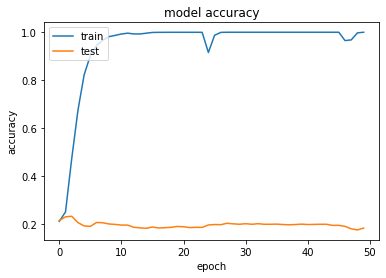

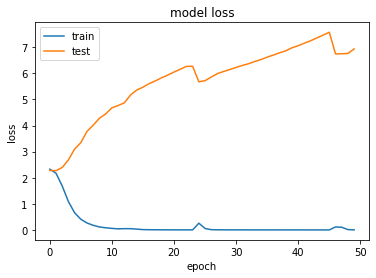

In [ ]:
import matplotlib.pyplot as plt

# model: drop out, two layers, 64-400-200-64-16
# model_1: no drop out, 64-400-200-64-16
# model_2: three layers: 256-400-200-100-64-16

file_name = "model_1_lr_"+str(lr)
# plot accuracy
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/"+file_name+"_acc.jpg"
plt.savefig(dpi=200, fname=path)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/"+file_name+"_loss.jpg"
plt.savefig(dpi=200, fname=path)
plt.show()

**PART[2]** **BERT PRETRAINED MODEL**

#### Model architecutre creation

In [ ]:
# applying bert model
maxlen = 512
def create_model_bert(): 
    input_word_ids = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32,
                                           name="input_word_ids")
    bert_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    bert_outputs = bert_layer(input_word_ids)[0]
    reduce = tf.keras.layers.Dense(50, activation='relu')(bert_outputs[:,0,:])
    pred = tf.keras.layers.Dense(16, activation='softmax')(reduce)
    
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00001), metrics=['accuracy'])
    return model

#### tokenize data into same model tokenizer (bert-base-uncased)

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')

train_input_ids = [tokenizer.encode(str(i), max_length = maxlen , pad_to_max_length = True) for i in train.cleaned_text.values]
val_input_ids = [tokenizer.encode(str(i), max_length = maxlen , pad_to_max_length = True) for i in val.cleaned_text.values]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#### check to use tpu or not

In [ ]:
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model_bert()
else:
    model = create_model_bert()
    
model.summary()

INFO:tensorflow:Initializing the TPU system: grpc://10.94.236.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.94.236.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                38450     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
Total params: 109,521,506
Trainable params: 109,521,506
Non-trainable params: 0
_________________________________________________________________


#### model training with certian batch_size

In [ ]:
batch_size = 64
tf.keras.backend.clear_session()

history = model.fit(np.array(train_input_ids), one_hot_labels,validation_data = (np.array(val_input_ids), val_labels),
          verbose = 1, epochs = 100, batch_size = batch_size)

Epoch 1/100


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 16) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 16) dtype=float32>]


109/109 [==============================] - ETA: 0s - loss: 2.3219 - accuracy: 0.2029

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 16) dtype=float32>]


109/109 [==============================] - 177s 864ms/step - loss: 2.3219 - accuracy: 0.2029 - val_loss: 2.2531 - val_accuracy: 0.2588
Epoch 2/100
109/109 [==============================] - 30s 279ms/step - loss: 2.1157 - accuracy: 0.3097 - val_loss: 2.0796 - val_accuracy: 0.3562
Epoch 3/100
109/109 [==============================] - 30s 278ms/step - loss: 1.7027 - accuracy: 0.4811 - val_loss: 1.5442 - val_accuracy: 0.5452
Epoch 4/100
109/109 [==============================] - 30s 278ms/step - loss: 1.3604 - accuracy: 0.5971 - val_loss: 1.3461 - val_accuracy: 0.6029
Epoch 5/100
109/109 [==============================] - 30s 278ms/step - loss: 1.2031 - accuracy: 0.6435 - val_loss: 1.2476 - val_accuracy: 0.6277
Epoch 6/100
109/109 [==============================] - 30s 278ms/step - loss: 1.0778 - accuracy: 0.6787 - val_loss: 1.2757 - val_accuracy: 0.6231
Epoch 7/100
109/109 [==============================] - 30s 278ms/step - loss: 0.9778 - accuracy: 0.7059 - val_loss: 1.3038 - val_accura

#### plotting results of trainning and validation process

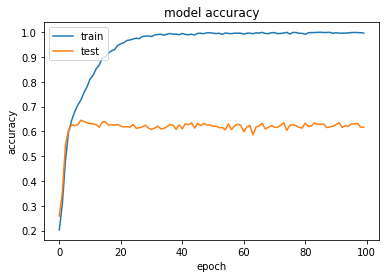

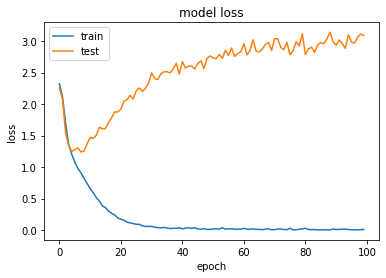

In [ ]:
import matplotlib.pyplot as plt

file_name = "model_overfit"
# plot accuracy
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/"+file_name+"_acc.jpg"
plt.savefig(dpi=150, fname=path)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/"+file_name+"_loss.jpg"
plt.savefig(dpi=150, fname=path)
plt.show()



**SMALLER BERT**

#### model architecture creation

In [ ]:
# applying bert model
maxlen = 512
def create_model_bert_smaller(): 
    input_word_ids = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32,
                                           name="input_word_ids")
    bert_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    bert_outputs = bert_layer(input_word_ids)[0]
    pred = tf.keras.layers.Dense(16, activation='softmax')(bert_outputs[:,0,:])
    
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001), metrics=['accuracy'])
    return model

#### check to use tpu or not

In [ ]:
  use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model_bert_smaller()
else:
    model = create_model_bert()
    
model.summary()

INFO:tensorflow:Initializing the TPU system: grpc://10.94.236.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.94.236.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                12304     
Total params: 109,494,544
Trainable params: 109,494,544
Non-trainable params: 0
_________________________________________________________________


#### model training with certain batch_size

In [ ]:
batch_size = 32
tf.keras.backend.clear_session()

history = model.fit(np.array(train_input_ids), one_hot_labels,validation_data = (np.array(val_input_ids), val_labels),
          verbose = 1, epochs = 10, batch_size = batch_size)

Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 16) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 16) dtype=float32>]


109/109 [==============================] - ETA: 0s - loss: 2.3271 - accuracy: 0.2107

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 16) dtype=float32>]


109/109 [==============================] - 182s 855ms/step - loss: 2.3271 - accuracy: 0.2107 - val_loss: 2.1952 - val_accuracy: 0.2605
Epoch 2/10
109/109 [==============================] - 31s 280ms/step - loss: 1.9329 - accuracy: 0.3674 - val_loss: 1.5831 - val_accuracy: 0.5043
Epoch 3/10
109/109 [==============================] - 30s 279ms/step - loss: 1.3905 - accuracy: 0.5634 - val_loss: 1.4165 - val_accuracy: 0.5522
Epoch 4/10
109/109 [==============================] - 30s 279ms/step - loss: 1.0433 - accuracy: 0.6733 - val_loss: 1.6613 - val_accuracy: 0.5614
Epoch 5/10
109/109 [==============================] - 30s 279ms/step - loss: 0.7796 - accuracy: 0.7581 - val_loss: 1.5921 - val_accuracy: 0.5816
Epoch 6/10
109/109 [==============================] - 30s 279ms/step - loss: 0.5672 - accuracy: 0.8290 - val_loss: 1.7296 - val_accuracy: 0.5527
Epoch 7/10
109/109 [==============================] - 30s 279ms/step - loss: 0.4144 - accuracy: 0.8756 - val_loss: 1.6875 - val_accuracy: 0.

#### plotting results of training and validation process

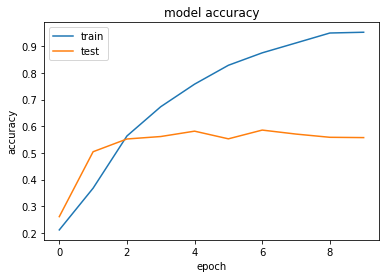

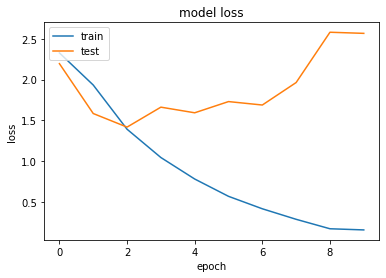

In [ ]:
import matplotlib.pyplot as plt

file_name = "model_smaller"
# plot accuracy
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/"+file_name+"_acc.jpg"
plt.savefig(dpi=150, fname=path)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/"+file_name+"_loss.jpg"
plt.savefig(dpi=150, fname=path)
plt.show()



**PREDICTIONS**

### this section covers the prediction code to predict a new custom text

In [ ]:
print(maxlen)
test_input_ids = [tokenizer.encode(str(i), max_length = maxlen , pad_to_max_length = True) for i in test.cleaned_text.values]
test_labels= tf.keras.utils.to_categorical(test.type_index.values, num_classes=16)

512


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def recreate_model(): 
    input_word_ids = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32,
                                           name="input_word_ids")
    bert_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    bert_outputs = bert_layer(input_word_ids)[0]
    pred = tf.keras.layers.Dense(16, activation='softmax')(bert_outputs[:,0,:])
    
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00001), metrics=['accuracy'])
    model.load_weights("drive/MyDrive/bert_base_model.h5")
    return model

In [ ]:
new_model = recreate_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_text = "i am ambitious, helpful. i love to go outside with my friends.i am creative, i like to try new things"
cleaned_ip = clean_text(input_text)
custom_test_ids = [tokenizer.encode(str(cleaned_ip),max_length = maxlen , pad_to_max_length = True)]
type_ind = np.argmax(new_model.predict(np.array(custom_test_ids)))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
per_types[type_ind]

'ISFP'